Copyright (C) 2023 Ming-Fong Sie <seansie07@gmail.com> & Yu-Jing Lin <elvisyjlin@gmail.com>

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

#### Some Abbreviations
1. cm: confusion matrix
2. rp: classification report
3. fi: feature importance
4. if: important features

In [1]:
# Import all used packages

import argparse
import collections
import json
import numpy as np
import os
import pandas as pd
import pickle
import sys
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score  # Add this import statement at the beginning

from tqdm import tqdm

from learn import get_model, get_params
from utils import run_from_ipython, np2df
from viz import show_cm_list, show_rp_list

if run_from_ipython():
    import matplotlib
    # %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
    import xgboost
    sns.set_context('notebook')  # 'notebook', 'paper', 'talk', 'poster'
    # sns.set_style('dark')  # None, 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

In [2]:
# Parse Arguments

def parse(args=None):
    parser = argparse.ArgumentParser(
        prog='Classification',
        description='Train and test a machine learning classification method on the extracted features.'
    )
    parser.add_argument('--n_folds', help='n folds cross validation', type=int, default=10)
    parser.add_argument('--model', '-m', help='model/method', type=str,
                        choices=['lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb'], default='xgb')
    parser.add_argument('--feature_type', '-f',
                        help='feature type ("b" | "e" | "m" or "if4", "if5", "if10", "if13", "if20", "if64")',
                        type=str, default='bem')
    parser.add_argument('--scheme', '-s', help='data scheme', type=str,
                        choices=['address', 'entity'], default='address')
    parser.add_argument('--n_jobs', '-j', help='number of workers/threads; set -1 to use all processors', type=int, default=10)
    parser.add_argument('--no_cost_sentitive', help='disable cost sentitive learning', action='store_true')
    parser.add_argument('--output', '-o', help='output path', type=str, default='./data_p')
    parser.add_argument('--result', '-r', help='result path', type=str, default='./result')
    return parser.parse_args() if args is None else parser.parse_args(args)
args = parse([]) if run_from_ipython() else parse()
print(args)

Namespace(feature_type='bem', model='xgb', n_folds=10, n_jobs=10, no_cost_sentitive=False, output='./data_p', result='./result', scheme='address')


In [3]:
# Define the experiment setting

n_folds = args.n_folds                       # 10
model = args.model                           # 'lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb'
feature_type = args.feature_type             # 'b' | 'e' | 'm' or 'if4', 'if5', 'if10', 'if13', 'if20', 'if64'
scheme = args.scheme                         # 'address', 'entity'
n_jobs = args.n_jobs                         # -1 to use all processors, or any positive integer
cost_sensitive = not args.no_cost_sentitive  # True, False
output_path = args.output
result_path = args.result

# Check the experiment setting

assert model in ['lr', 'p', 'ab', 'rf', 'svm', 'xgb', 'lgb']
assert not feature_type.startswith('if') and len(feature_type) > 0 or \
       feature_type.startswith('if') and feature_type[2:].isdigit()
# assert scheme in ['address', 'entity']
assert scheme in ['address']

# Show the experiment setting

print('Experiment Setting')
print('===> Model:         ', model)
print('===> Feature Types: ', feature_type)
print('===> Data Scheme:   ', scheme)
print('===> Cost Sensitive:', cost_sensitive)
print('===> N Threads:     ', n_jobs)

Experiment Setting
===> Model:          xgb
===> Feature Types:  bem
===> Data Scheme:    address
===> Cost Sensitive: True
===> N Threads:      10


In [4]:
# Load transaction history summarization data

# data_file = 'data.{}.csv'.format(scheme)
# data_file = 'quantum_qubo_data.{}.csv'.format(scheme)
data_file = 'all_selected_features_quantum_qubo_data.{}.csv'.format(scheme)
data = pd.read_csv(os.path.join(output_path, data_file))
print (data)
if run_from_ipython():
    data.head(4)
else:
    print(data.head(4))

        n_tx  total_days  total_spent_btc  total_received_btc  \
0        1.0         1.0         0.011048            0.011048   
1        2.0        91.0         0.714653            0.714653   
2        1.0         1.0         0.999000            0.999000   
3        5.0        30.0        40.642063           40.642063   
4        1.0         1.0         0.035000            0.035000   
...      ...         ...              ...                 ...   
212757   2.0        21.0         1.051200            1.051200   
212758   7.0       104.0         0.765639            0.765639   
212759   1.0         1.0         0.011394            0.011394   
212760   4.0         6.0        10.173900           10.173900   
212761   2.0         1.0         0.600000            0.600000   

        total_spent_usd  total_received_usd  mean_balance_btc  \
0              2.918842                   0          0.011048   
1            188.487957                   0          0.357326   
2            351.280357 

In [5]:
# Define 3 types of features (basic statistics, extra statistics, and moments)

basic = [
    'f_tx', 'f_received', 'f_coinbase',
    'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0',
    'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4',
    'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2',
    'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2',
    'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6',
    'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent'
]
extra = [
    'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback',
    'total_spent_btc', 'total_received_btc',
    'total_spent_usd', 'total_received_usd',
    'mean_balance_btc', 'std_balance_btc',
    'mean_balance_usd', 'std_balance_usd'
]
moments = [
    'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment',
    'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment',
    'dist_coinbase_1st_moment', 'dist_coinbase_2nd_moment', 'dist_coinbase_3rd_moment', 'dist_coinbase_4th_moment',
    'dist_spend_1st_moment', 'dist_spend_2nd_moment', 'dist_spend_3rd_moment', 'dist_spend_4th_moment',
    'dist_receive_1st_moment', 'dist_receive_2nd_moment', 'dist_receive_3rd_moment', 'dist_receive_4th_moment',
    'dist_payback_1st_moment', 'dist_payback_2nd_moment', 'dist_payback_3rd_moment', 'dist_payback_4th_moment'
]

features = []
if not feature_type.startswith('if') and len(feature_type) > 0:
    if 'b' in feature_type:
        features += basic
    if 'e' in feature_type:
        features += extra
    if 'm' in feature_type:
        features += moments
elif feature_type.startswith('if') and feature_type[2:].isdigit():
    """
    Important features from LightGBM with BEM
    [ 0 25 24 29 40 37 27 23 56 36  1 28 26 57 32 38 44 45 33 18 39 60 53 35
     34 52 41 17 14 15 16 19 42  5  6 47  7 46  2 54  4 43  8 59 58 55  9 13
     61 48  3 31 10 62 20 21 63 30 49 11 51 50 22 12]
    """
    all_features = basic + extra + moments
    if_indices = [
        0, 25, 24, 29, 40, 37, 27, 23, 56, 36,
        1, 28, 26, 57, 32, 38, 44, 45, 33, 18,
        39, 60, 53, 35, 34, 52, 41, 17, 14, 15,
        16, 19, 42, 5, 6, 47, 7, 46, 2, 54,
        4, 43, 8, 59, 58, 55, 9, 13, 61, 48,
        3, 31, 10, 62, 20, 21, 63, 30, 49, 11,
        51, 50, 22, 12
    ]
    if_features = [all_features[i] for i in if_indices]
    n_if = int(feature_type[2:])
    features = if_features[:n_if]
else:
    raise Exception('Invalid feature types: {:s}'.format(feature_type))

invalid_features = [feature for feature in features if feature not in data.columns]
assert len(invalid_features) == 0, 'Invalid features: ' + ', '.join(invalid_features)

X = data.get(features).values
y = data['class'].values
print (features)
print (feature_type)
print (X)
print (y)

class2label = json.loads(open(os.path.join(output_path, 'class2label.json'), 'r').read())
label2class = json.loads(open(os.path.join(output_path, 'label2class.json'), 'r').read())
class_names = np.array([label2class[i] for i in range(6)])
print (class_names)
y_names = class_names
# y_names = class_names[y]
# y_names = np.array(class_names)[y.astype(int)]

print(len(X), len(y), len(features))

os.makedirs(result_path, exist_ok=True)

['f_tx', 'f_received', 'f_coinbase', 'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0', 'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4', 'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2', 'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2', 'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6', 'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent', 'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback', 'total_spent_btc', 'total_received_btc', 'total_spent_usd', 'total_received_usd', 'mean_balance_btc', 'std_balance_btc', 'mean_balance_usd', 'std_balance_usd', 'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment', 'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment', 'dist_coinbase_1st_moment', 'dist_coinbase_2n

{'Exchange': 0, 'Faucet': 1, 'Gambling': 2, 'Market': 3, 'Mixer': 4, 'Pool': 5}
     0    1    2    3    4    5    6    7    8    9   ...        54   55   56  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.880978  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.284748  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.249329  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  

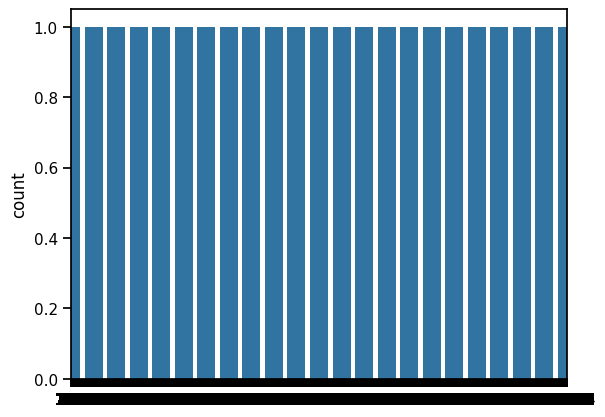

In [6]:
def data_distribution(df):
    if run_from_ipython():
        plt.figure()
        sns.countplot(df.index)
    cnt = collections.Counter(df.index)
    print(cnt)
    return np.array([cnt[i] for i in range(len(cnt))])

print(class2label)
data_dict = np2df(X, y)
print(data_dict)
y_count = data_distribution(data_dict)
# y_count = data_distribution(np2df(X, y))

In [9]:
# Training procedure

train_cm_list = []
train_rp_list = []
valid_cm_list = []
valid_rp_list = []
fi_list = []

# Add these lists to store AUC scores
train_auc_list = []
valid_auc_list = []

# Model parameters
clf_params = get_params(model)
if model not in ['ab', 'svm']:
    clf_params['n_jobs'] = n_jobs
print('Hyper-parameters:')
print(clf_params)

# Declare K-Fold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Normalize data
# Note that decision tree sbased algorithms need no data normalization
if model in ['lr', 'p', 'svm']:
    print('Normalizing data...')
    X = np.nan_to_num(X / np.abs(X).max(axis=0))

# Start cross validation
for train_idx, valid_idx in tqdm(skf.split(X, y)):
    # print(train_idx[:100], valid_idx[:10])
    
    # Retrieve splitted training set and validating set
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    # Calculate sample weight (whether to apply cost sensitive learning)
    sample_weight = np.ones((len(y_train), ), dtype='float64')
    if cost_sensitive:
        sample_weight = class_weight.compute_sample_weight('balanced', y_train)
    
    # Declare the classifier and train it on the training set
    clf = get_model(model, clf_params)
    # clf.fit(X_train, y_train)
    clf.fit(X_train, y_train, sample_weight=sample_weight)
    
    # Evaluate on the training set
    y_pred = clf.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    train_cm_list.append(cm)
    rp = classification_report(y_train, y_pred, target_names=class_names, output_dict=True)
    train_rp_list.append(rp)
    
    # Evaluate on the validating set
    y_pred = clf.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    valid_cm_list.append(cm)
    rp = classification_report(y_valid, y_pred, target_names=class_names, output_dict=True)
    valid_rp_list.append(rp)
    
    # Get the feature importances according to the trained model
    if model in ['rf', 'xgb', 'lgb']:
        if 'booster' in clf_params and clf_params['booster'] == 'dart':
            pass
        else:
            fi = clf.feature_importances_
            fi_list.append(fi)
            
    # Calculate AUC for the training set
    y_train_prob = clf.predict_proba(X_train)
    train_auc = roc_auc_score(y_train, y_train_prob, multi_class="ovr", average="macro")
    train_auc_list.append(train_auc)

    # Calculate AUC for the validation set
    y_valid_prob = clf.predict_proba(X_valid)
    valid_auc = roc_auc_score(y_valid, y_valid_prob, multi_class="ovr", average="macro")
    valid_auc_list.append(valid_auc)

Hyper-parameters:
{'n_estimators': 1000, 'importance_type': 'gain', 'n_jobs': 10}


10it [07:08, 42.87s/it]


In [10]:
# Save training results

experiment_name = os.path.join(result_path, '{}.{}.{}'.format(model, feature_type, scheme))
if not cost_sensitive:
    experiment_name += '.no_cs'
results = {
    'train_cm_list': train_cm_list,
    'valid_cm_list': valid_cm_list,
    'train_rp_list': train_rp_list,
    'valid_rp_list': valid_rp_list,
    'fi_list': fi_list
}
pickle.dump(results, open(experiment_name + '.pkl', 'wb'))

In [ ]:
# Average confusion matrix of training set in K-fold

print('Average confusion matrix of training set in {:d}-fold'.format(n_folds))
show_cm_list(train_cm_list, class_names)

In [11]:
def show_rp_list(rp_list):
    # Initialize a dictionary to hold the summed metrics
    summed_metrics = {}
    
    # Iterate over each report in the list
    for report in rp_list:
        for category, metrics in report.items():
            # Check if metrics is a dictionary
            if isinstance(metrics, dict):
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        summed_metrics[category][metric] += value
            else:
                # Handle the case where metrics is a float (like 'accuracy')
                if category not in summed_metrics:
                    summed_metrics[category] = 0
                summed_metrics[category] += metrics

    # Now calculate the average
    avg_metrics = {}
    for category, metrics in summed_metrics.items():
        if isinstance(metrics, dict):
            avg_metrics[category] = {metric: value / len(rp_list) for metric, value in metrics.items()}
        else:
            # Average for float values
            avg_metrics[category] = metrics / len(rp_list)

    # Print the average metrics
    for category, metrics in avg_metrics.items():
        print(f"Category: {category}")
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                print(f"  {metric}: {value}")
        else:
            print(f"  Value: {metrics}")
        print()

# Average classification report of training set in K-fold

print('Average classification report of training set in {:d}-fold'.format(n_folds))
show_rp_list(train_rp_list)

Average classification report of training set in 10-fold
Category: Exchange
  precision: 0.7739694167838799
  recall: 0.6257812583822356
  f1-score: 0.692024781056632

Category: Faucet
  precision: 0.3197677518815122
  recall: 0.8424860295054055
  f1-score: 0.4635632759822208

Category: Gambling
  precision: 0.623278042484758
  recall: 0.5829183179855725
  f1-score: 0.6024105437544763

Category: Market
  precision: 0.9260938692975269
  recall: 0.6884234968635742
  f1-score: 0.7897622520134625

Category: Mixer
  precision: 0.4035034166211588
  recall: 0.8773261965201847
  f1-score: 0.5527676454676913

Category: Pool
  precision: 0.9037856869930512
  recall: 0.7927345756694766
  f1-score: 0.8446156596484375

Category: accuracy
  Value: 0.6959847674426629

Category: macro avg
  precision: 0.6583996973436479
  recall: 0.7349449791544083
  f1-score: 0.6575240263204868

Category: weighted avg
  precision: 0.7768025320255678
  recall: 0.6959847674426629
  f1-score: 0.7158116900395021



Average confusion matrix of validataion set in 10-fold


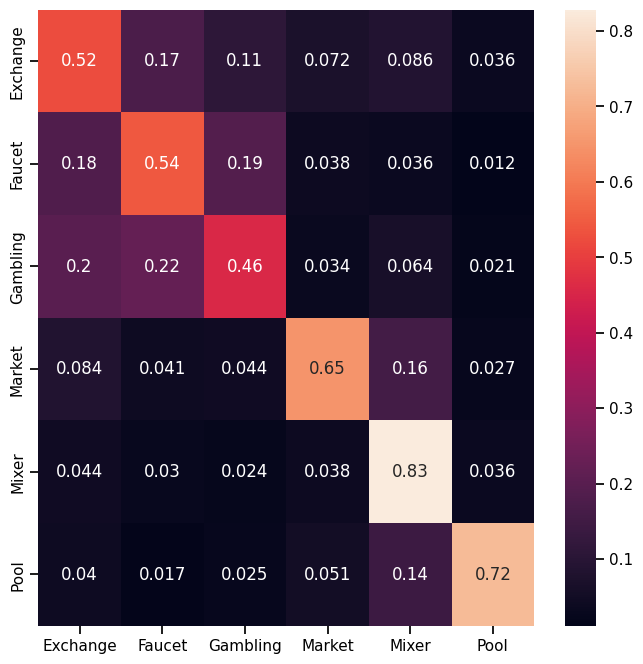

In [12]:
# Average confusion matrix of validataion set in K-fold

print('Average confusion matrix of validataion set in {:d}-fold'.format(n_folds))
show_cm_list(valid_cm_list, class_names)

In [13]:
# Average classification report of validataion set in K-fold

print('Average classification report of validataion set in {:d}-fold'.format(n_folds))
show_rp_list(valid_rp_list)

Average classification report of validataion set in 10-fold
Category: Exchange
  precision: 0.6629684742533077
  recall: 0.5249770243233993
  f1-score: 0.5859368456811465

Category: Faucet
  precision: 0.20425301118441014
  recall: 0.5412684468210702
  f1-score: 0.29655521098349263

Category: Gambling
  precision: 0.49982027768239207
  recall: 0.45770809232749593
  f1-score: 0.477802308925438

Category: Market
  precision: 0.8584794037814859
  recall: 0.6472805455100495
  f1-score: 0.738055854333317

Category: Mixer
  precision: 0.37798415002958347
  recall: 0.828076879419173
  f1-score: 0.5190333285390694

Category: Pool
  precision: 0.8180695839413324
  recall: 0.7247685712060098
  f1-score: 0.768560772751832

Category: accuracy
  Value: 0.612350892814706

Category: macro avg
  precision: 0.570262483478752
  recall: 0.6206799266011996
  f1-score: 0.5643240535357159

Category: weighted avg
  precision: 0.689097912053598
  recall: 0.612350892814706
  f1-score: 0.6331642822773486



gain
[29 40 34 57 36 32 27 26 52 41 42 30 47 46 48 19 20 18 21 17 16 15 63 13
 14 23 12 11 10  9  8  7  6  5  4  3  2  1 22 31 24 25 61 60 59 58 56 55
 54 53 51 50 49 45 44 43 39 38 37 35 33 62 28  0]


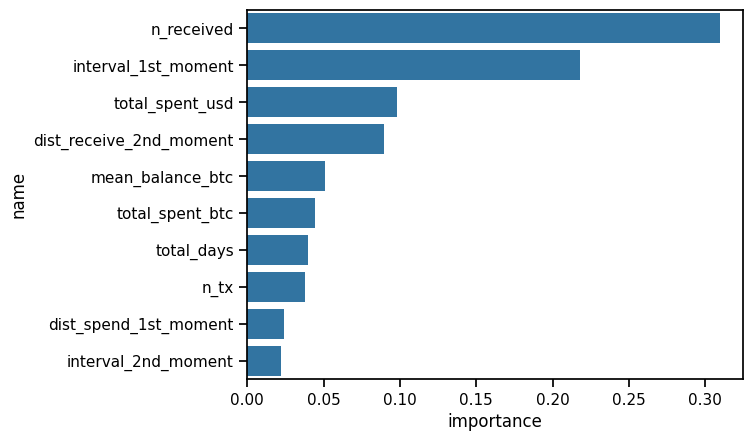

In [14]:
# Feature Importance

if len(fi_list) == 0:
    exit()
    sys.exit()

try:
    print(clf.importance_type)
except Exception as e:
    print(e)

fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_top_10 = df_feature_importances.nlargest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_top_10)  # Modified this line


In [15]:
if run_from_ipython():
    plt.figure(figsize=(16, 32))
    for i in range(10):
        feature_index = df_top_10.index[i]
        feature_name = list(df_top_10['name'])[i]
        feature_data = X[:, feature_index]

        # Check if the lengths match
        if len(y_names) != len(feature_data):
            print(f"Length mismatch for feature '{feature_name}': Length of y_names is {len(y_names)}, length of feature data is {len(feature_data)}")
            continue  # Skip this iteration

        plt.subplot(5, 2, i+1)
        plt.title(feature_name)
        ax = sns.boxplot(x=y_names, y=feature_data)


Length mismatch for feature 'n_received': Length of y_names is 6, length of feature data is 212762
Length mismatch for feature 'interval_1st_moment': Length of y_names is 6, length of feature data is 212762
Length mismatch for feature 'total_spent_usd': Length of y_names is 6, length of feature data is 212762
Length mismatch for feature 'dist_receive_2nd_moment': Length of y_names is 6, length of feature data is 212762
Length mismatch for feature 'mean_balance_btc': Length of y_names is 6, length of feature data is 212762
Length mismatch for feature 'total_spent_btc': Length of y_names is 6, length of feature data is 212762
Length mismatch for feature 'total_days': Length of y_names is 6, length of feature data is 212762
Length mismatch for feature 'n_tx': Length of y_names is 6, length of feature data is 212762
Length mismatch for feature 'dist_spend_1st_moment': Length of y_names is 6, length of feature data is 212762
Length mismatch for feature 'interval_2nd_moment': Length of y_nam

<Figure size 1600x3200 with 0 Axes>

[29 40 34 57 36 32 27 26 52 41 42 30 47 46 48 19 20 18 21 17 16 15 63 13
 14 23 12 11 10  9  8  7  6  5  4  3  2  1 22 31 24 25 61 60 59 58 56 55
 54 53 51 50 49 45 44 43 39 38 37 35 33 62 28  0]


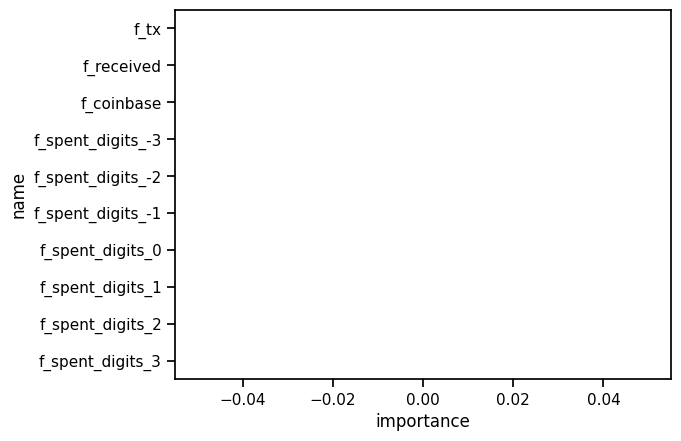

In [16]:
fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_least_10 = df_feature_importances.nsmallest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_least_10)  # Corrected this line


[29 40 34 57 36 32 27 26 52 41 42 30 47 46 48 19 20 18 21 17 16 15 63 13
 14 23 12 11 10  9  8  7  6  5  4  3  2  1 22 31 24 25 61 60 59 58 56 55
 54 53 51 50 49 45 44 43 39 38 37 35 33 62 28  0]


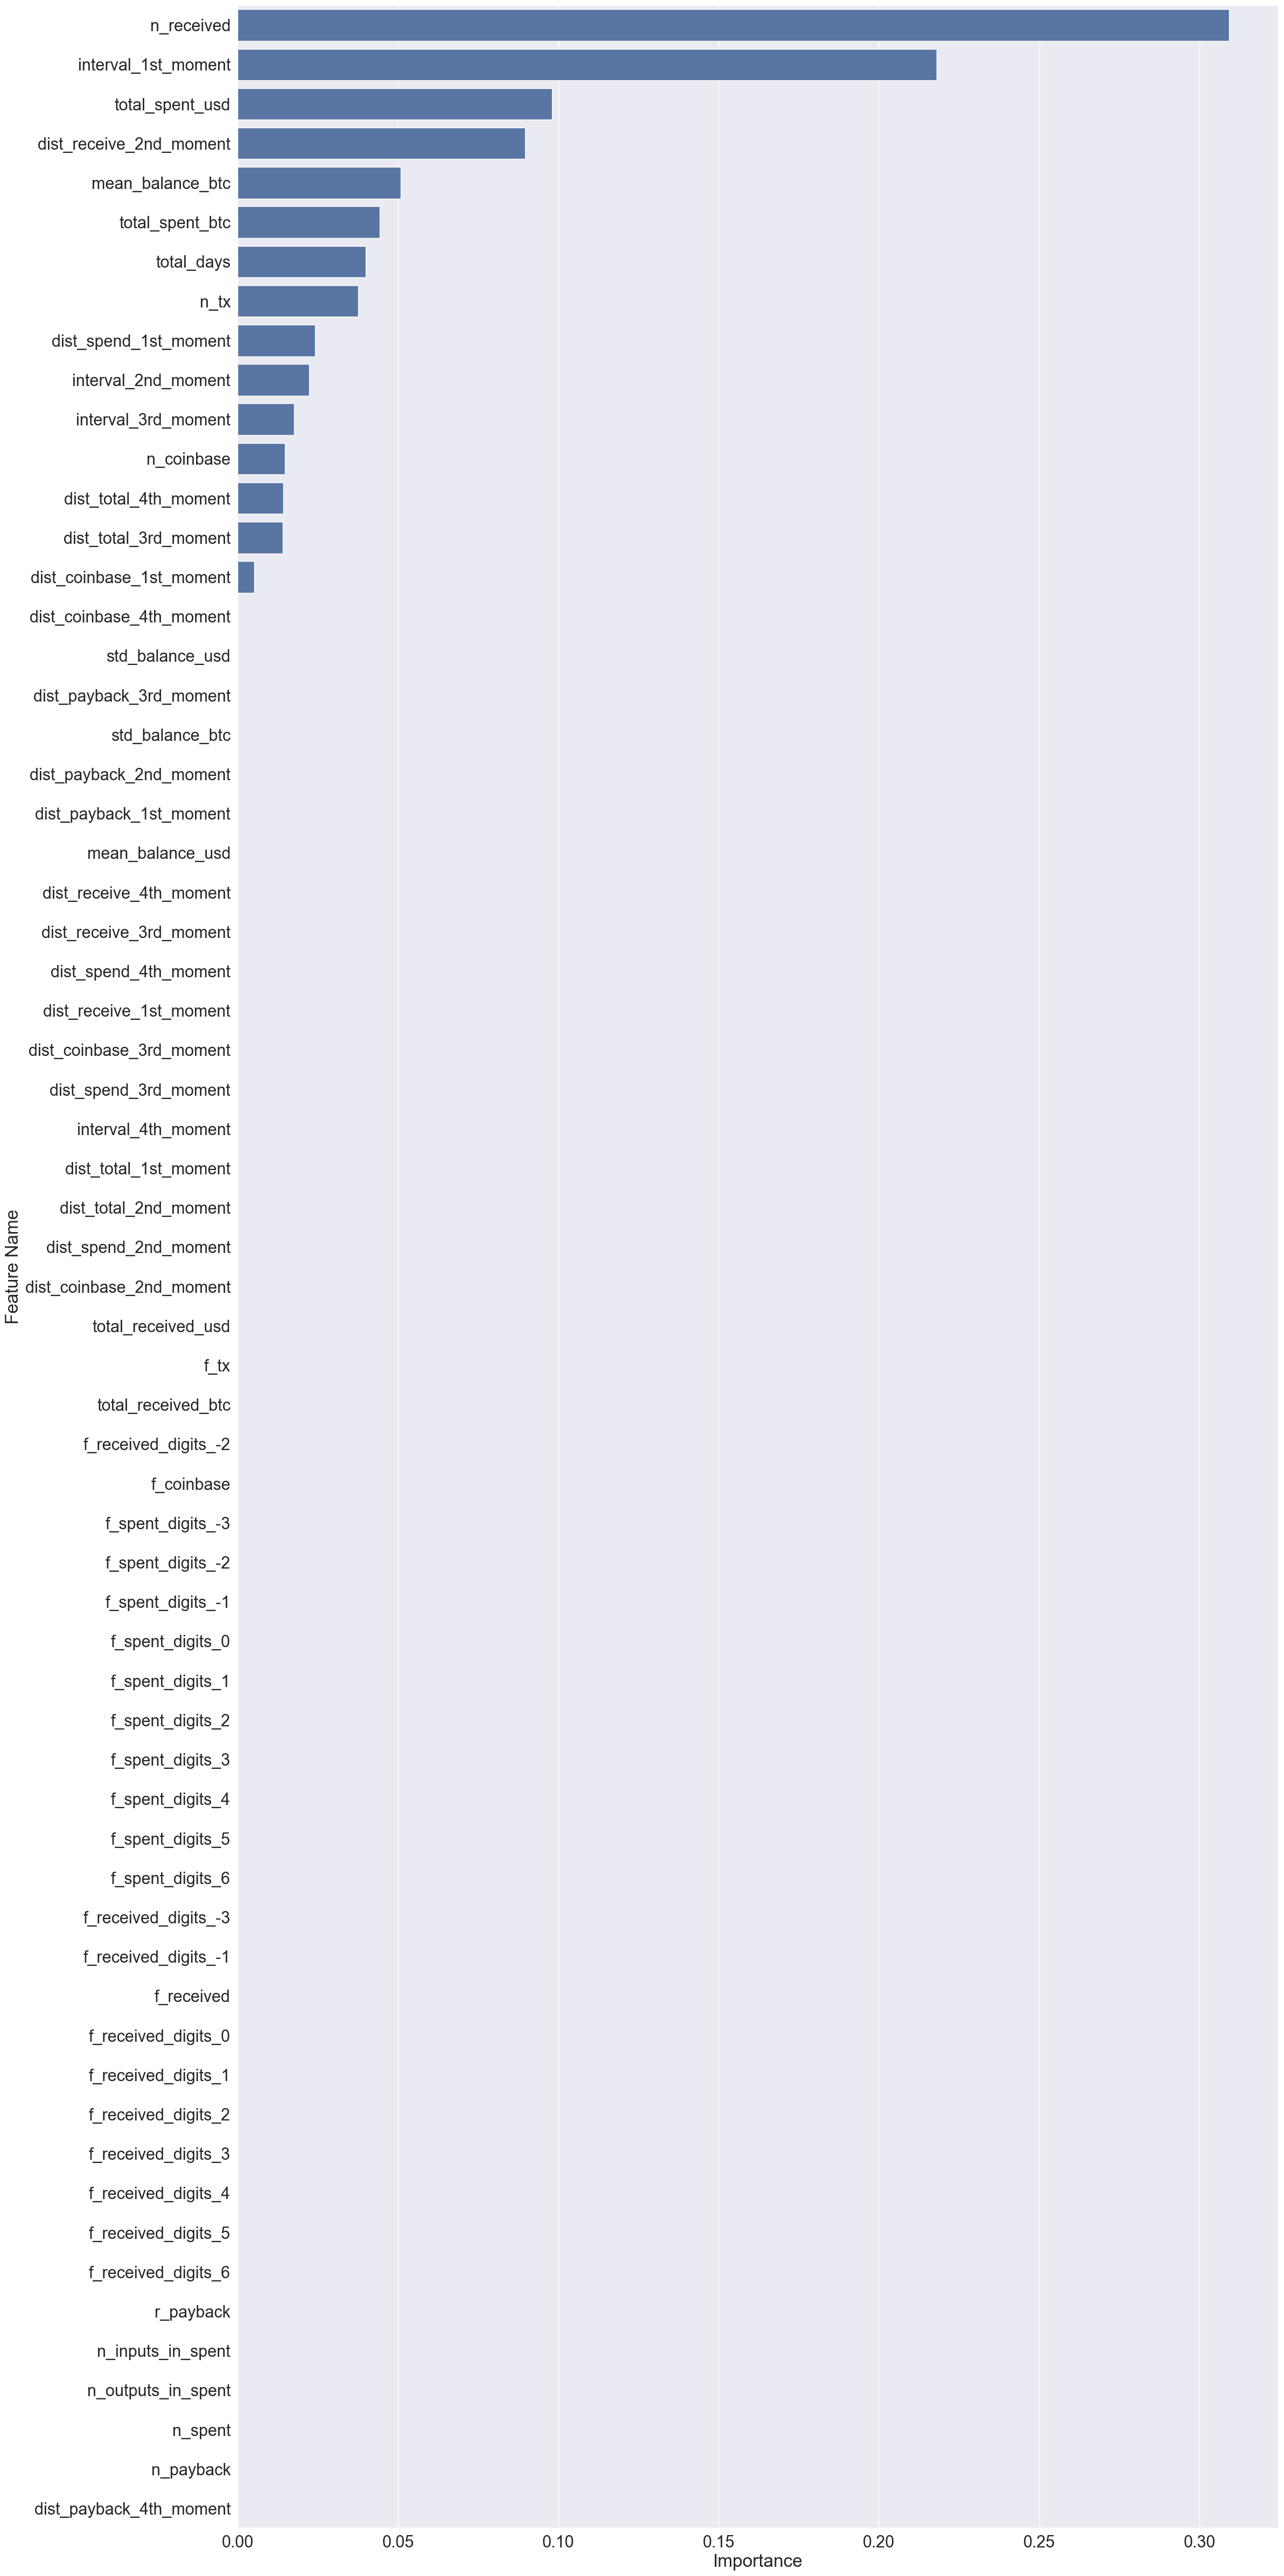

In [17]:
fi_avg = np.mean(fi_list, axis=0)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'Feature Name': features, 'Importance': fi_avg})
    df_least_10 = df_feature_importances.nlargest(len(features), columns='Importance')
    plt.figure(figsize=(24, 48))
    sns.set(font_scale=2)
    sns.barplot(x='Importance', y='Feature Name', data=df_least_10)  # Corrected this line
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('top_10_and_last_10_feature_importance.png')  # Uncomment this line to save the figure


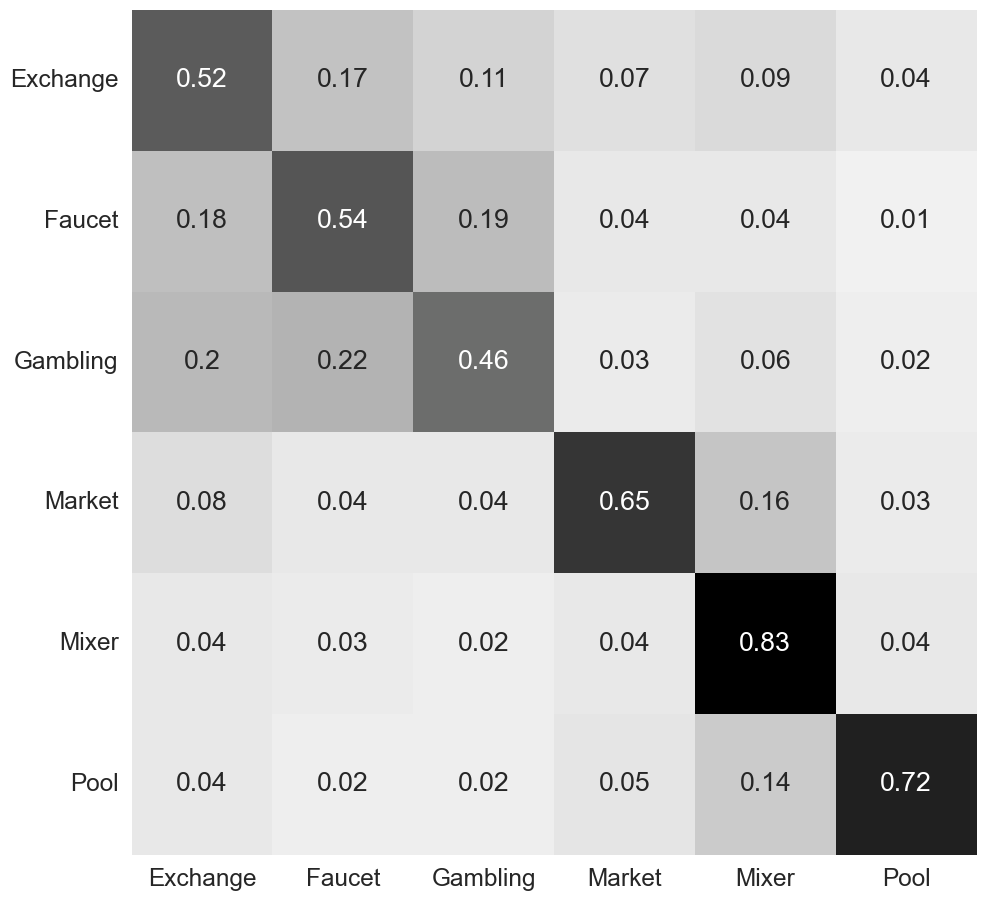

In [18]:
from matplotlib.colors import ListedColormap

cm_avg = np.mean(valid_cm_list, axis=0)
# print(cm_avg)
if run_from_ipython():
    df_cm = pd.DataFrame(cm_avg, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 10))
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = sns.light_palette('black', as_cmap=True)
    # cmap = ListedColormap(['white'])
    sns.set(font_scale=1.6)
    sns.heatmap(df_cm.round(2), annot=True, square=True, cbar=False, cmap=cmap)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('confusion_matrix.png')  # Uncomment this line to save the figure

Average Training Confusion Matrix:
[[6.25781258e-01 1.45777816e-01 8.94223133e-02 3.90182159e-02
  8.25432221e-02 1.74571745e-02]
 [4.00898755e-02 8.42486030e-01 8.76765001e-02 1.80541490e-03
  2.71052313e-02 8.36948727e-04]
 [1.49141108e-01 1.86979700e-01 5.82918318e-01 1.77398350e-02
  5.53579312e-02 7.86310775e-03]
 [6.67394916e-02 3.59061146e-02 3.83112135e-02 6.88423497e-01
  1.54051239e-01 1.65684446e-02]
 [3.66729182e-02 2.44308483e-02 1.50128496e-02 2.51834973e-02
  8.77326197e-01 2.13736901e-02]
 [1.90829377e-02 1.42719698e-02 1.74496033e-02 2.43458957e-02
  1.32115018e-01 7.92734576e-01]]

Average Validation Confusion Matrix:
[[0.52497702 0.1722209  0.10914178 0.07158783 0.08565066 0.0364218 ]
 [0.18347327 0.54126845 0.18949663 0.03798593 0.03615461 0.01162112]
 [0.20080885 0.22233834 0.45770809 0.03373648 0.06432778 0.02108045]
 [0.08392526 0.0405632  0.04372775 0.64728055 0.15777993 0.02672332]
 [0.04435919 0.03009305 0.02361812 0.03770628 0.82807688 0.03614648]
 [0.0404327

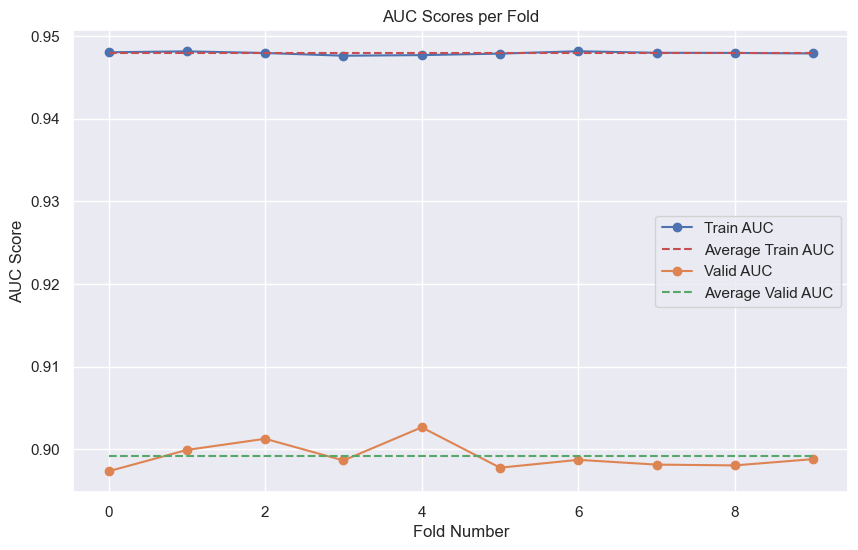

In [19]:
import matplotlib.pyplot as plt

# 计算平均混淆矩阵
avg_train_cm = np.mean(train_cm_list, axis=0)
avg_valid_cm = np.mean(valid_cm_list, axis=0)

# 计算平均AUC分数
avg_train_auc = np.mean(train_auc_list)
avg_valid_auc = np.mean(valid_auc_list)

# 展示平均混淆矩阵
print("Average Training Confusion Matrix:")
print(avg_train_cm)
print("\nAverage Validation Confusion Matrix:")
print(avg_valid_cm)

# 展示平均AUC分数
print(f"\nAverage Train AUC: {avg_train_auc}")
print(f"Average Valid AUC: {avg_valid_auc}")

# 绘制AUC分数图表
plt.figure(figsize=(10, 6))
plt.plot(train_auc_list, label='Train AUC', marker='o')
plt.plot([avg_train_auc] * len(train_auc_list), 'r--', label='Average Train AUC')
plt.plot(valid_auc_list, label='Valid AUC', marker='o')
plt.plot([avg_valid_auc] * len(valid_auc_list), 'g--', label='Average Valid AUC')
plt.title('AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('AUC Score')
plt.legend()
plt.show()